In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict,relative=False):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        if not relative:
            df = results_dict[k].results_capacities
        else:
            df = results_dict[k].results_capacity_change
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta


def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs


def export_results_for_chord(merged_results,scenario):
    '''Export a csv for chord plots
    '''
    df = merged_results[scenario].results_edge_flows.copy()

    df['from_territory'] = ''
    df['to_territory'] = ''
    df = df[df.from_id.str.contains('generation')].reset_index(drop=True)

    df.loc[df.from_id.str.contains('israel'),'from_territory'] = 'ISR'
    df.loc[df.from_id.str.contains('west_bank'),'from_territory'] = 'WBK'
    df.loc[df.from_id.str.contains('gaza'),'from_territory'] = 'GZA'
    df.loc[df.from_id.str.contains('jordan'),'from_territory'] = 'JOR'
    df.loc[df.from_id.str.contains('egypt'),'from_territory'] = 'EGY'

    df.loc[df.to_id.str.contains('israel'),'to_territory'] = 'ISR'
    df.loc[df.to_id.str.contains('west_bank'),'to_territory'] = 'WBK'
    df.loc[df.to_id.str.contains('gaza'),'to_territory'] = 'GZA'
    df.loc[df.to_id.str.contains('jordan'),'to_territory'] = 'JOR'
    df.loc[df.to_id.str.contains('egypt'),'to_territory'] = 'EGY'
    
    df = df[['from_territory','to_territory','value']]
    df = df.groupby(by=['from_territory','to_territory']).sum().reset_index()
    
    # units?
    df.value = df.value.divide(10**3)
    # save
    df.to_csv('plots/chord_data/' + scenario + '.csv',index=False)
    print('done.')
    
    
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    '''Estimate SOx emissions in tonnes
    '''
    df['sox'] = df[on] * df['technology'].map(sox) * 10**-6
    return df


def map_nox_emissions(df,on):
    '''Estimate NOx emissions in tonnes
    '''
    df['nox'] = df[on] * df['technology'].map(nox) * 10**-6
    return df


def map_co2_emissions(df,on):
    '''Estimate CO2 emissions in tonnes
    '''
    df['co2'] = df[on] * df['technology'].map(co2) * 10**-6
    return df

def map_water_use(df,on):
    df['water_use'] = df[on] * df['technology'].map(water_use)
    return df

## Load scenario results

In [3]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

In [4]:
# export_results_for_chord(results,scenario='BAU')
# export_results_for_chord(results,scenario='NCO')
# export_results_for_chord(results,scenario='EAG')
# export_results_for_chord(results,scenario='COO')
# export_results_for_chord(results,scenario='UTO')

## Plot: summary of scenario analysis

This figure shows: 

    a. Total cost ($) by scenario
    b. Total capacity (GW) by scenario and technology
    c. Summary of various variables by scenario (e.g., NOx, SOx etc.)

In [5]:
merged_flows = pd.DataFrame()
for k in results.keys():
    sn = get_source_nodes(results[k].nodes).name.to_list()
    df = results[k].results_edge_flows.loc[results[k].results_edge_flows.from_id.isin(sn)]
    df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
    df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
    df = map_territory(df,on='from_id')
    df = map_technology(df,on='from_id')
    merged_flows = merged_flows.append(df,ignore_index=True)

merged_flows = map_sox_emissions(merged_flows,on='value')
merged_flows = map_nox_emissions(merged_flows,on='value')
merged_flows = map_co2_emissions(merged_flows,on='value')
merged_flows = map_water_use(merged_flows,on='value')

# calculate annual sums
merged_flows = merged_flows.groupby(by=['year','scenario']).sum().reset_index()

monthly_means = merged_flows.groupby(by=['year','scenario']).mean().reset_index()

# rename total demand column
monthly_means['demand'] = monthly_means['value']

# compute monthly means
#monthly_means = merged_flows.groupby(by=['year','scenario']).mean().reset_index()
monthly_means = monthly_means[['scenario','sox','nox','co2','water_use','demand']]

# append capacities
capacities = merge_capacity_data(results)
#capacities = capacities.groupby(by=['technology','scenario']).max().reset_index()
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value',
                                    aggfunc='sum')

battery = capacities['Battery'].to_dict()
monthly_means['battery'] = monthly_means.scenario.map(battery)

def normalise_column(df,columns):
    df = monthly_means.copy()
    for i in columns:
        column=i
        baseline_value = df.loc[df.scenario=='BAS',column].values[0]
        df[column] = ((df[column]-baseline_value)/baseline_value)*100
    return df

monthly_means_normalised = normalise_column(monthly_means,columns=['nox','co2','sox','water_use'])
#monthly_means = monthly_means[monthly_means.scenario != 'BAS'].reset_index(drop=True)

hls_colours = sns.color_palette("Spectral", as_cmap=True)

## Export cost data for plotting in R
This step computes total expenditures (TOTEX) and exports to a csv. The csv is then in an R script to create a bar chart plot.

In [6]:
# ************************************************************************* ----
# COSTS ----
# ************************************************************************* ----

costs = merge_cost_data(results)

# pivot table
costs = costs.pivot_table(index=['scenario','territory'],
                          columns=['technology'],
                          values='totex',
                          aggfunc='sum').reset_index(drop=False)

# compute totex
costs['total'] = costs.sum(axis=1)
# reindex
costs = costs[['scenario','territory','total']]
# sort by totex
costs = costs.sort_values('total')
# divide to convert to billion
costs['total'] = costs['total'].divide(10**9)
# append totals for each scenario
sum_cost = costs.groupby(by='scenario').sum().reset_index()
sum_cost['territory'] = 'Total'
costs = costs.append(sum_cost,ignore_index=True)
# save
costs.to_csv('../outputs/results/merged_totex_results.csv',index=False)


# ************************************************************************* ----
# ABSOLUTE CAPACITIES ----
# ************************************************************************* ----

caps = merge_capacity_data(results)
caps.to_csv('../outputs/results/merged_capacity_results.csv',index=False)

# ************************************************************************* ----
# RELATIVE CAPACITIES ----
# ************************************************************************* ----

capacity_changes = merge_capacity_data(results,relative=True)
# remove gas storage node
capacity_changes = capacity_changes[capacity_changes.node != 'israel_gas_storage'].reset_index(drop=True)
# change ccgt
capacity_changes.node = capacity_changes.node.str.replace('ccgt','natural_gas')
# group natural gas nodes
capacity_changes = capacity_changes.groupby(by=['node','territory','scenario','technology']).sum().reset_index()
# append net capacity addition
net_capacity = capacity_changes.groupby(by=['territory','scenario']).sum().reset_index()
net_capacity['technology'] = 'Net change'
capacity_changes = capacity_changes.append(net_capacity,ignore_index=True)
# save
capacity_changes.to_csv('../outputs/results/merged_capacity_changes.csv',index=False)

In [7]:
monthly_means['carbon_intensity'] = monthly_means['co2'].divide(monthly_means['demand']) * 10**6 # g/kWh
monthly_means

,scenario,sox,nox,co2,water_use,demand,battery,carbon_intensity
0,BAS,10.277871,30.833613,60896.384837,5.113241e+06,1.299377e+08,6.552480e+05,468.658402
1,BAU,7.229613,21.745403,42940.100000,3.427327e+06,1.422507e+08,5.775500e+07,301.862226
2,COO,7.247274,21.741823,42940.100000,3.605519e+06,1.314985e+08,1.754226e+07,326.544469
3,EAG,7.229688,21.745388,42940.100000,3.428083e+06,1.375431e+08,3.864346e+07,312.193679
4,NCO,7.229616,21.745402,42940.100000,3.427359e+06,1.463463e+08,9.630361e+07,293.414356


In [8]:
# scenario = 'EAG'
# region = 'israel'
# node = region + '_battery_storage'
# month=1

# f,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True)

# results[scenario].plot_battery_storage_volume(node=node,days=2,month=month,ax=ax[0])
# results[scenario].plot_supply_curve(region=region,days=2,month=month,ax=ax[1],shade_battery_charge=True)

# ax[1].set_xlim([1,48])
# #plt.xticks(np.arange(0, 26, 2.0))

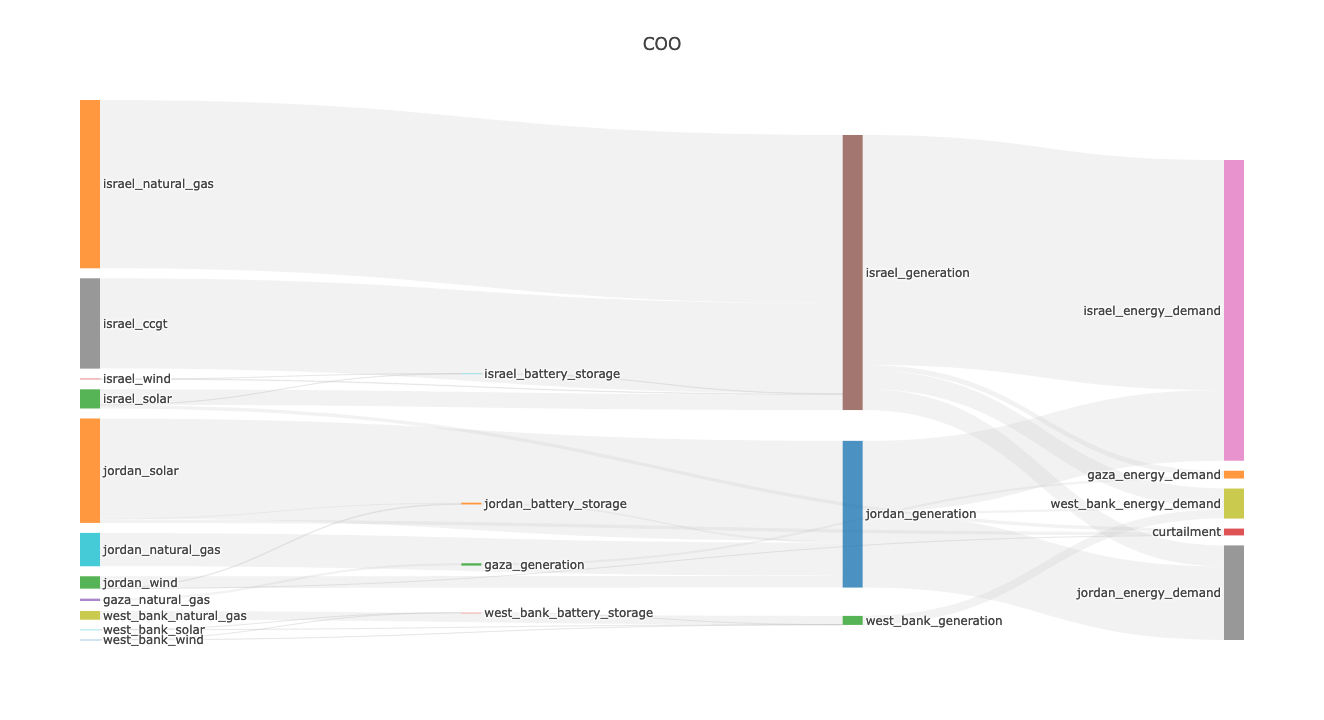

In [12]:
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pio.renderers.default = 'iframe'

scenario='COO'

fig = results[scenario].plot_flows_sankey(title=scenario)
pio.write_image(fig, f'../outputs/figures/OMS_sankey_{scenario}.png',scale=4, width=1100, height=700)

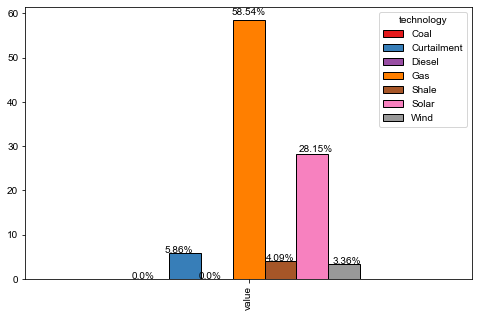

In [10]:
results['EAG'].plot_total_supply(cmap='Set1')

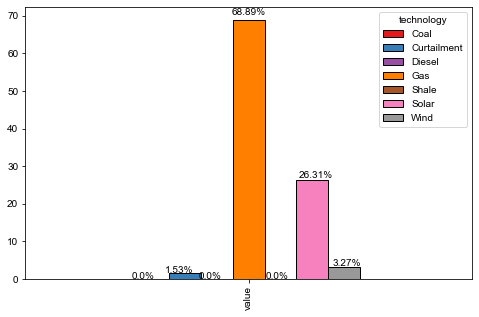

In [11]:
results['COO'].plot_total_supply(cmap='Set1')

In [12]:
results['BAU'].results_capacity_change.sort_values(by='capacity_change',ascending=False).head(10)

,node,capacity_change,technology,territory,scenario
1,israel_solar,14263.779620,Solar,Israel,BAU
2,israel_natural_gas,8149.617186,Gas,Israel,BAU
12,west_bank_solar,5755.754606,Solar,West Bank,BAU
25,west_bank_battery_storage,3424.877123,Battery,West Bank,BAU
7,jordan_solar,3133.097202,Solar,Jordan,BAU
23,israel_battery_storage,1800.277962,Battery,Israel,BAU
20,gaza_solar,1510.171271,Solar,Gaza,BAU
26,gaza_battery_storage,948.855009,Battery,Gaza,BAU
19,jordan_shale,762.491131,Shale,Jordan,BAU
0,israel_wind,614.000000,Wind,Israel,BAU


In [13]:
def compare_costs(scenario):
    c = results[scenario].results_costs[results[scenario].results_costs.totex > 0].sort_values(by='totex',ascending=False)
    c.capex = c.capex.divide(10**6)
    c.opex = c.opex.divide(10**6)
    c.totex = c.totex.divide(10**6)
    return c

scenario_1 = 'COO'
scenario_2 = 'EAG'

COO = compare_costs(scenario_1)
BAU = compare_costs(scenario_2)

pdiff = (COO.totex.sum() - BAU.totex.sum()) / BAU.totex.sum() *100

if pdiff > 0:
    print(scenario_1 + ' is ' + str(pdiff.round(2)) + '% more expensive than ' + scenario_2 + ' :(')
else:
    print(scenario_1 + ' is ' + str(pdiff.round(2)) + '% cheaper than ' + scenario_2 + ' !!!')

COO is -22.77% cheaper than EAG !!!


In [14]:
COO

,node,capacity_change,technology,territory,capex,opex,totex,scenario
2,israel_natural_gas,9734.484438,Gas,Israel,4633.614593,973.448444,5607.063036,COO
7,jordan_solar,17690.758747,Solar,Jordan,3729.211944,88.453794,3817.665738,COO
24,jordan_battery_storage,1997.335166,Battery,Jordan,1886.523011,29.960027,1916.483038,COO
6,jordan_wind,1304.592908,Wind,Jordan,869.380714,13.045929,882.426643,COO
16,west_bank_natural_gas,336.401365,Gas,West Bank,160.127050,33.640137,193.767186,COO
21,gaza_natural_gas,90.156647,Gas,Gaza,42.914564,9.015665,51.930229,COO
13,west_bank_wind,50.000000,Wind,West Bank,33.320000,0.500000,33.820000,COO
25,west_bank_battery_storage,5.205638,Battery,West Bank,4.916829,0.078085,4.994913,COO


In [15]:
BAU

,node,capacity_change,technology,territory,capex,opex,totex,scenario
2,israel_natural_gas,8057.245752,Gas,Israel,3835.248978,805.724575,4640.973553,EAG
1,israel_solar,13031.477880,Solar,Israel,2747.035537,65.157389,2812.192927,EAG
26,gaza_battery_storage,2028.000000,Battery,Gaza,1915.486560,30.420000,1945.906560,EAG
23,israel_battery_storage,1638.302002,Battery,Israel,1547.409007,24.574530,1571.983537,EAG
8,jordan_natural_gas,1608.586354,Gas,Jordan,765.687105,160.858635,926.545740,EAG
6,jordan_wind,1207.410668,Wind,Jordan,804.618469,12.074107,816.692576,EAG
7,jordan_solar,3715.102461,Solar,Jordan,783.143599,18.575512,801.719111,EAG
19,jordan_shale,861.706463,Shale,Jordan,688.503464,86.170646,774.674110,EAG
24,jordan_battery_storage,590.051313,Battery,Jordan,557.315266,8.850770,566.166036,EAG
20,gaza_solar,2535.000000,Solar,Gaza,534.378000,12.675000,547.053000,EAG


## Looking at Palestinian self-sufficiency

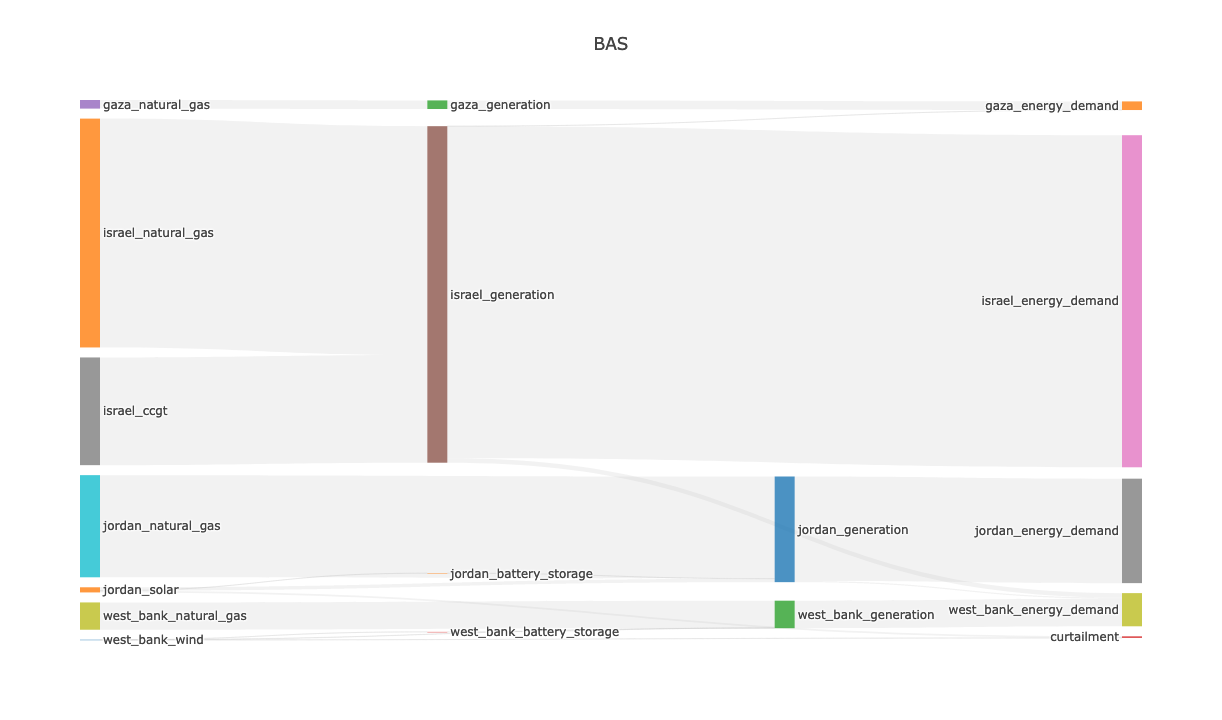

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'node': {'pad': 10,
    'line': {'color': 'black', 'width': 0},
    'label': 0              egypt_generation
    1          gaza_battery_storage
    2                   gaza_diesel
    3               gaza_generation
    4              gaza_natural_gas
    5                    gaza_solar
    6        israel_battery_storage
    7                   israel_ccgt
    8                   israel_coal
    9                 israel_diesel
    10            israel_generation
    11           israel_natural_gas
    12                 israel_solar
    13                  israel_wind
    14       jordan_battery_storage
    15                  jordan_ccgt
    16                  jordan_coal
    17                jordan_diesel
    18            jordan_generation
    19           jordan_natural_gas
    20                 jordan_shale
    21                 jordan_solar
    22        

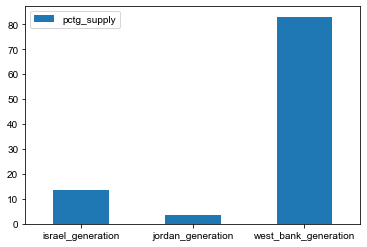

In [16]:
region='west_bank'
scenario='BAS'
results[scenario].plot_self_sufficiency(region=region)
results[scenario].get_self_sufficiency(region=region)
results[scenario].plot_flows_sankey(title=scenario)